# Problem analysis and data extracting

We have been given the problem of gender voice recognition (binary classification) where the dataset needs to be extracted and proccessed by ourselves (just like real life, not kaggle datasets). In this notebook we will present an exploraty data analysis for the dataset and some proposed models along with some comments on how and why things are done.

Before passing to the EDA we first explain how the dataset was extracted. The data extracting and dataset process consist of 3 files attached along this notebook:

**Scraper.py**: Simple file to find and download all the tgz files from the provided url for the problem.

**dataset.py**: File where tgz files are explored and wavs files along some extra features from the other files are extracted(such as age, dialect, fileType, channels and more metadata). This file creates a csv file containing the path for each wav file along the features extracted.

**scriptR.R**: A parallelized R script where the warbleR library for audio processing is used, the file reads the previous csv and appends the features obtained from the [&lt;Specan function&gt;](https://www.rdocumentation.org/packages/warbleR/versions/1.1.14/topics/specan) to create the dataset we will be using in this notebook.

This 3 files have been coded to run locally on my machine with my specific paths, in the case the project needed to automatize this data extraction we should add arg.parsers so they scale and add correct coding policies such as exception handling.


# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score,log_loss, matthews_corrcoef
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils import resample
from scipy import stats
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics  
from sklearn.grid_search import GridSearchCV  

from bayes_opt import BayesianOptimization
import contextlib
import gc
import contextlib

target='gender'
tf.set_random_seed(17)
np.random.seed(17)
#mirar tiempos de ejecucion de cad amodelo en predecir
#mejorar el scraper de dialect

# EDA


## Load the dataset and get a brief overview

In [101]:
dataframe=pd.read_csv("audios_dataset.csv")
dataframeOriginal =pd.read_csv("audios_dataset.csv") #backup in case we need to access original df after transforming it
print('\nDataframe shape: {}'.format(dataframe.shape))


Dataframe shape: (86647, 41)


Lets see the features our dataset is composed of

In [102]:
dataframe.head(5)

,Unnamed: 0,sound.files,user,age,gender,language,dialect,fileType,rate,rateFormat,...,maxfun,meandom,mindom,maxdom,dfrange,modindx,startdom,enddom,dfslope,meanpeakf
0,1,audio1.wav,topherfangio,Adult,male,EN,AmericanEnglishn,wav,48000,16,...,5.333333,0.319481,0.03125,3.46875,3.43750,6.109091,0.56250,0.06250,0.0,0.110491
1,2,audio10.wav,topherfangio,Adult,male,EN,AmericanEnglishn,wav,48000,16,...,5.333333,0.889381,0.03125,6.78125,6.75000,5.509259,0.21875,1.65625,0.0,0.078869
2,3,audio100.wav,Peter,Adult,male,EN,CanadianEnglishn,wav,48000,16,...,5.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047247
3,4,audio1000.wav,anonymous,adult,male,EN,AmericanEnglishn,wav,48000,16,...,5.333333,0.334746,0.03125,0.56250,0.53125,8.882353,0.37500,0.40625,0.0,0.047247
4,5,audio10000.wav,LAVEENAZ,Adult,male,EN,AmericanEnglishn,wav,48000,16,...,5.333333,0.868608,0.03125,4.81250,4.78125,6.921569,0.62500,0.03125,0.0,0.047247


In [103]:
#All the feature types
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86647 entries, 0 to 86646
Data columns (total 41 columns):
Unnamed: 0     86647 non-null int64
sound.files    86647 non-null object
user           86647 non-null object
age            86647 non-null object
gender         85093 non-null object
language       82088 non-null object
dialect        86647 non-null object
fileType       86067 non-null object
rate           86647 non-null int64
rateFormat     85762 non-null object
channels       85623 non-null float64
selec          86647 non-null int64
duration       86647 non-null float64
meanfreq       86647 non-null float64
sd             86647 non-null float64
freq.median    86647 non-null float64
freq.Q25       86647 non-null float64
freq.Q75       86647 non-null float64
freq.IQR       86647 non-null float64
time.median    86647 non-null float64
time.Q25       86647 non-null float64
time.Q75       86647 non-null float64
time.IQR       86647 non-null float64
skew           86647 non-null f

We observe that we have a majority of continous features (good for our models) and some of the features have different non-null numbers of rows, meaning some of them will have nulls or Nan (we will deal with them later).

Now we will get rid of the columns that won't give us any extra information such as index/ audio.name /user (a user has one unique gender) that have any sense be in the final model.

In [104]:
#drop the trash column, probably the index
dataframe.drop('duration',inplace=True,axis=1)
dataframe.drop('sound.files',inplace=True,axis=1)
dataframe.drop('Unnamed: 0',inplace=True,axis=1)
dataframe.drop('user',inplace=True,axis=1)
dataframe.drop('rate',inplace=True,axis=1)

In [105]:
continuousFeatures = dataframe.select_dtypes(include=['float64','int64']).columns
categoricalFeatures = dataframe.select_dtypes(include='object').columns

Let's see a sample of our categorical featues

In [106]:
dataframe[categoricalFeatures].head(10)

,age,gender,language,dialect,fileType,rateFormat
0,Adult,male,EN,AmericanEnglishn,wav,16
1,Adult,male,EN,AmericanEnglishn,wav,16
2,Adult,male,EN,CanadianEnglishn,wav,16
3,adult,male,EN,AmericanEnglishn,wav,16
4,Adult,male,EN,AmericanEnglishn,wav,16
5,Adult,male,EN,AmericanEnglishn,wav,16
6,Adult,male,EN,AmericanEnglishn,wav,16
7,Adult,male,EN,AmericanEnglishn,wav,16
8,Adult,male,EN,AmericanEnglishn,wav,16
9,Adult,male,EN,AmericanEnglishn,wav,16


rateFormat may not be a categorical feature but all others seem correct. We will deal with rateFormat in preprocessing

A sample of our dataset at the moment

In [107]:
dataframe.head()

,age,gender,language,dialect,fileType,rateFormat,channels,selec,meanfreq,sd,...,maxfun,meandom,mindom,maxdom,dfrange,modindx,startdom,enddom,dfslope,meanpeakf
0,Adult,male,EN,AmericanEnglishn,wav,16,1.0,1,1.624672,1.751428,...,5.333333,0.319481,0.03125,3.46875,3.43750,6.109091,0.56250,0.06250,0.0,0.110491
1,Adult,male,EN,AmericanEnglishn,wav,16,1.0,1,1.879392,1.847794,...,5.333333,0.889381,0.03125,6.78125,6.75000,5.509259,0.21875,1.65625,0.0,0.078869
2,Adult,male,EN,CanadianEnglishn,wav,16,1.0,1,2.766250,1.862706,...,5.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047247
3,adult,male,EN,AmericanEnglishn,wav,16,1.0,1,0.981539,1.490405,...,5.333333,0.334746,0.03125,0.56250,0.53125,8.882353,0.37500,0.40625,0.0,0.047247
4,Adult,male,EN,AmericanEnglishn,wav,16,1.0,1,2.298092,1.945568,...,5.333333,0.868608,0.03125,4.81250,4.78125,6.921569,0.62500,0.03125,0.0,0.047247


## Target variable analysis

We now want to study our target variable analysis, see how many classes(should be two, but maybe they have errors in typing) and how they are distributed and also get rid of nulls/nans

In [108]:
dataframe.gender.unique()

array(['male', 'female', nan], dtype=object)

In [109]:
#There are some samples with nan in the gender, we cant use them
dataframe.dropna(subset=['gender'],inplace=True)


In [110]:
dataframe.gender.describe()

count     85093
unique        2
top        male
freq      72161
Name: gender, dtype: object

In [111]:
print("Total number of labels: {}".format(dataframe.shape[0]))
print("Number of male: {}".format(dataframe[dataframe.gender == 'male'].shape[0]))
print("Number of female: {}".format(dataframe[dataframe.gender == 'female'].shape[0]))
print("Target variable balance: {0}{1}".format( (dataframe[dataframe.gender == 'male'].shape[0]) / (dataframe.shape[0]),"% males"))

Total number of labels: 85093
Number of male: 72161
Number of female: 12932
Target variable balance: 0.8480251019472812% males


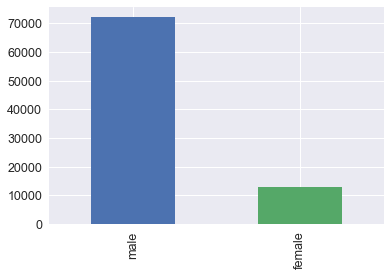

In [112]:
dataframe['gender'].value_counts().plot(kind='bar')
plt.show()

We see that our target variable is terribly balanced (as usual) we will deal with that in later sections.

In [113]:
#we are also going to encode the target variable female=1 male=0 to make things easier for our models
dataframe['gender'] = dataframe['gender'].map({'female': 1, 'male': 0})

In [114]:
dataframe.head()

,age,gender,language,dialect,fileType,rateFormat,channels,selec,meanfreq,sd,...,maxfun,meandom,mindom,maxdom,dfrange,modindx,startdom,enddom,dfslope,meanpeakf
0,Adult,0,EN,AmericanEnglishn,wav,16,1.0,1,1.624672,1.751428,...,5.333333,0.319481,0.03125,3.46875,3.43750,6.109091,0.56250,0.06250,0.0,0.110491
1,Adult,0,EN,AmericanEnglishn,wav,16,1.0,1,1.879392,1.847794,...,5.333333,0.889381,0.03125,6.78125,6.75000,5.509259,0.21875,1.65625,0.0,0.078869
2,Adult,0,EN,CanadianEnglishn,wav,16,1.0,1,2.766250,1.862706,...,5.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.047247
3,adult,0,EN,AmericanEnglishn,wav,16,1.0,1,0.981539,1.490405,...,5.333333,0.334746,0.03125,0.56250,0.53125,8.882353,0.37500,0.40625,0.0,0.047247
4,Adult,0,EN,AmericanEnglishn,wav,16,1.0,1,2.298092,1.945568,...,5.333333,0.868608,0.03125,4.81250,4.78125,6.921569,0.62500,0.03125,0.0,0.047247


## Independent variables analysis

We now present a study of both continuous and categorical features, studying its distributions against target variable gender and the correlations between them.

### Continous features

In [115]:
#For the rest of the expriment we will transform nans in continouos features with 0
dataframe[continuousFeatures] = dataframe[continuousFeatures].fillna(value=0)

We want to know how our features distributed when comparing them to the gender target, we want to evaluate the distributions for every single feature when having gender male against female. If we are able to find features with different distributions for each gender we will in fact very lucky as probably that feature will be an important one for our models. 


c:\users\jiwidi\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
c:\users\jiwidi\appdata\local\programs\python\python36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
c:\users\jiwidi\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


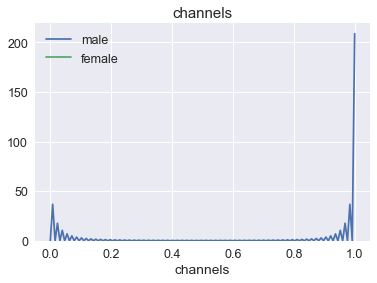

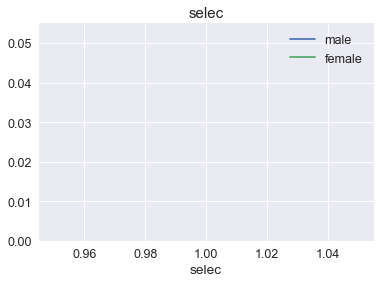

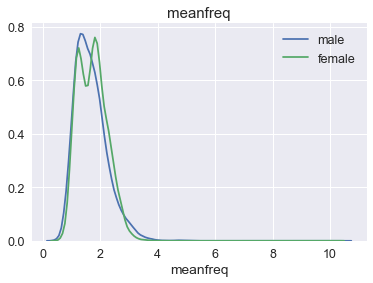

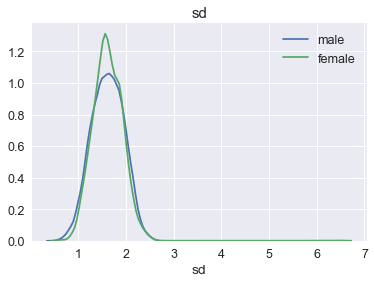

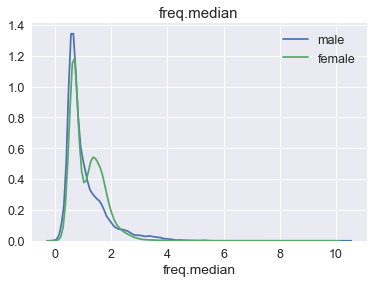

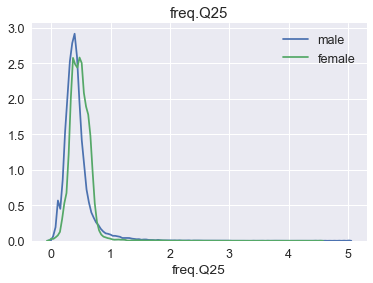

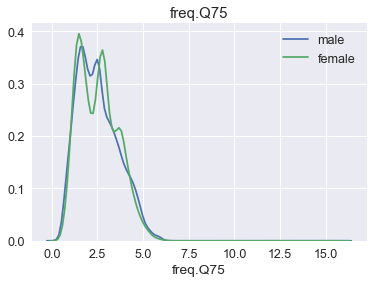

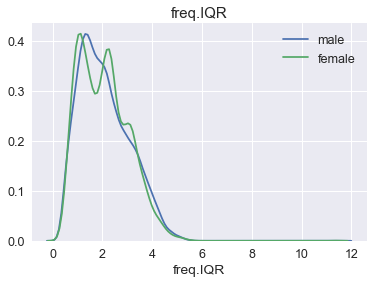

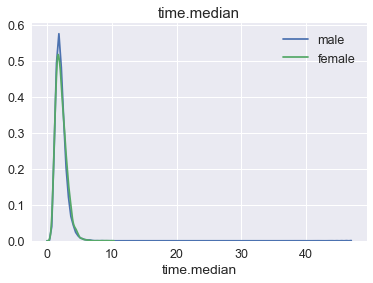

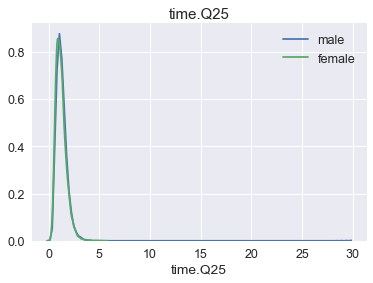

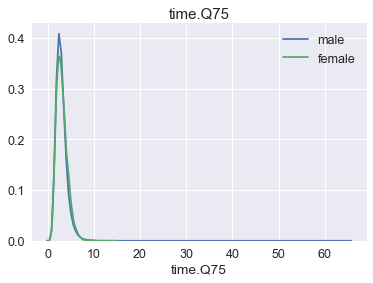

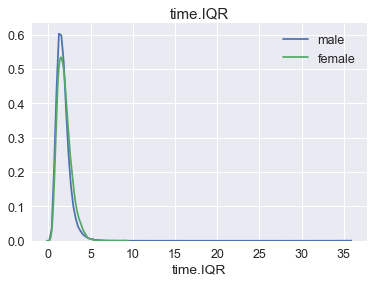

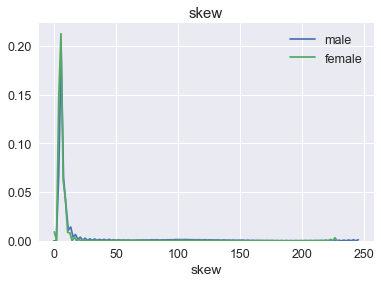

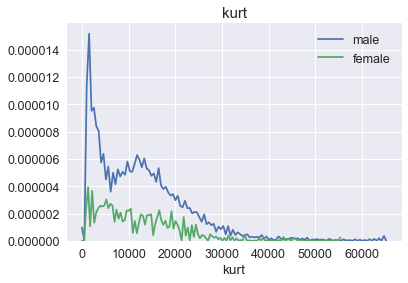

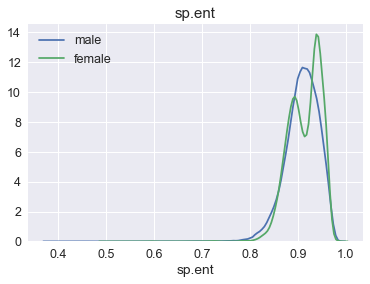

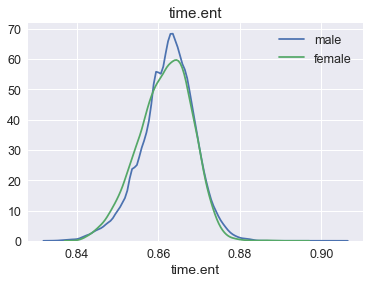

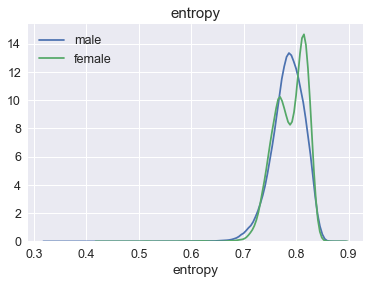

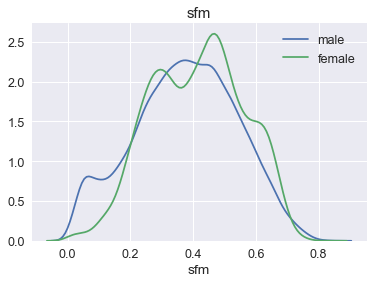

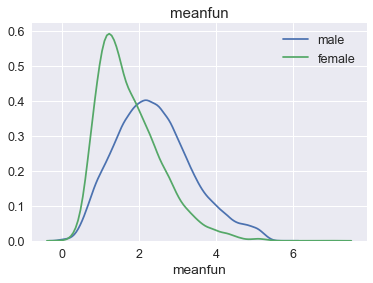

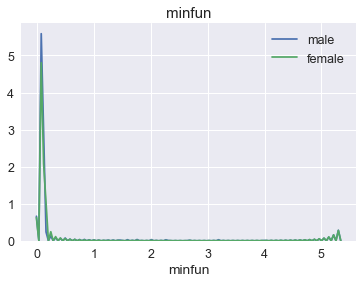

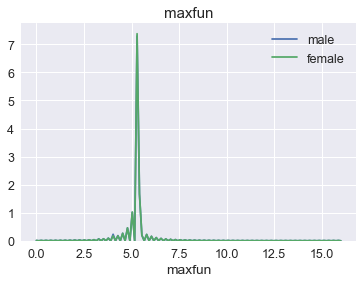

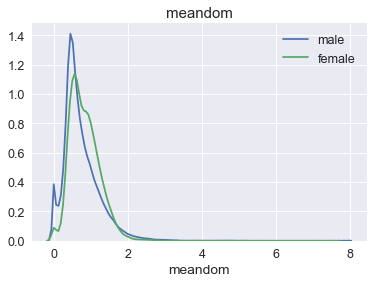

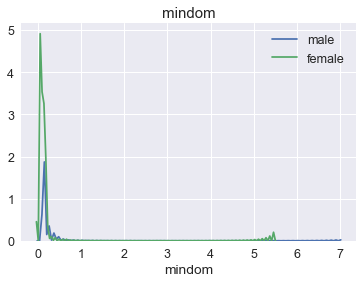

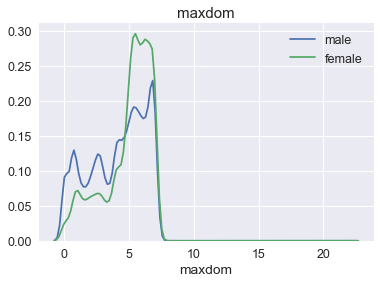

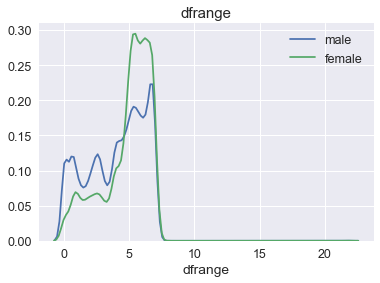

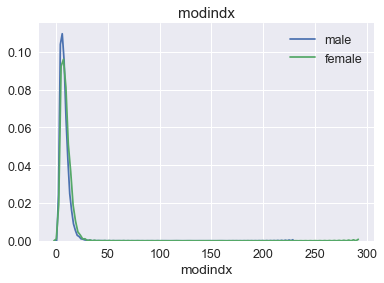

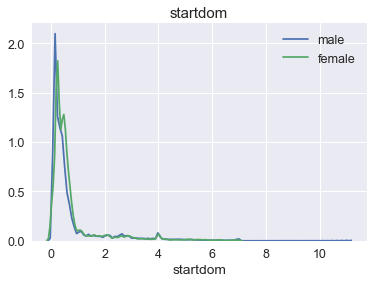

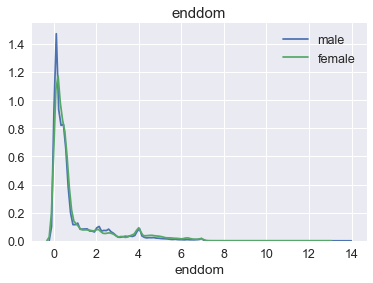

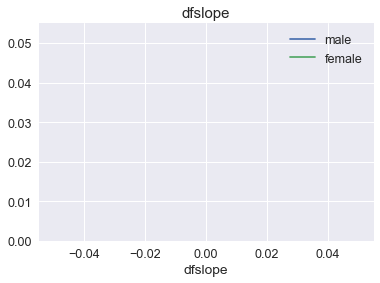

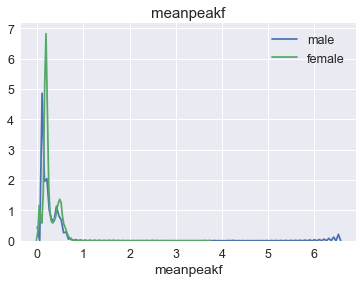

In [116]:
#Plot features distributions distinguing by the target variable gender
for idx,column in enumerate(continuousFeatures):
    try:
        target_0 = dataframe.loc[dataframe['gender'] == 0]
        target_1 = dataframe.loc[dataframe['gender'] == 1]

        sns.distplot(target_0[column], hist=False,label='male')
        sns.distplot(target_1[column], hist=False,label='female').set_title(column)
        plt.legend()
        plt.show()
    except:
        pass


With the features distribution of male against female we get a insight of features that could be important for our model. We classify them in 3 groups depending on how much the distributions differed.

**Notable difference**:
kurt,meanfun,mindom,maxdom,,dfrange. 

**Sligh differences**:
sd,frq.median,sp.ent,time.ent,entropy,sfm,meandom,meanpeakf 

**Almost no difference**:
select,channels,.modindx,startdom,enddom,dfslope,minfun,maxfun,meanfreq,freq.q25,freq.q75,feq.IQR,time.median,time.q25,time.q75,time.IQR,skew

We will keep this groups in mind for our geature extraction in the next sections


Another way of studying our features is to see the correlation matrix of the dataset, we can see how features correlate with gender (meaning they will be good for our models) but also correlations between features to check if we have duplicate "information" in 2 features.

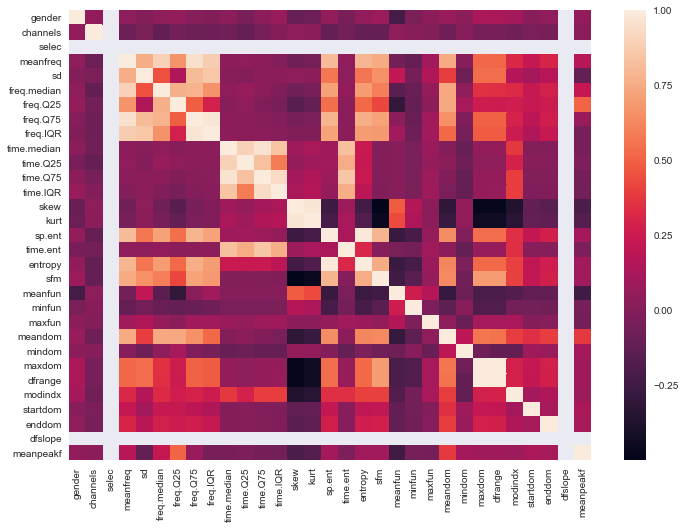

In [117]:
#Correlation map
corrmat = dataframe.corr()


sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corrmat)

First we see the big correlated features dfslope and slope, thats due to them having constant values so we will ignore them. In other features we are not able to see high correlations with the color scheme, let's print the values to get a better perspective


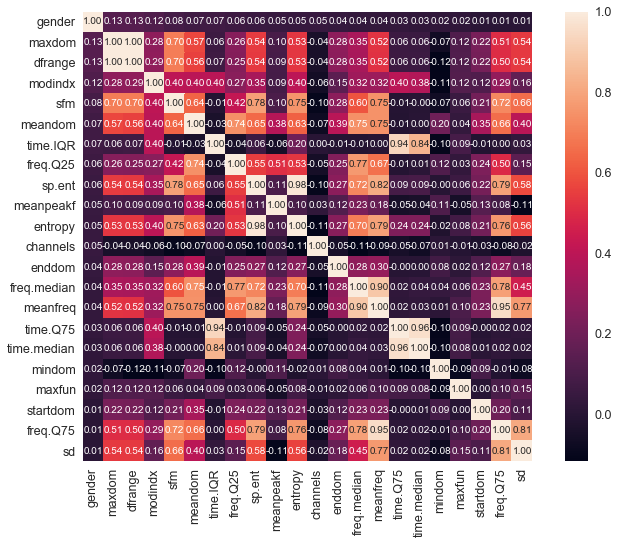

In [118]:
#Correlations map with the target variable
#saleprice correlation matrix
k = 22 #number of variables for heatmap
cols = corrmat.nlargest(k, 'gender')['gender'].index
cm = np.corrcoef(dataframe[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Now we can see how entropy and sp.ent are highly correlated(0.98) and also freq.Q75 and meanfreq (0.95). We don't observe any other high correlations in the matrix.

The correlation of the features with the target variable is almost zero for all, thay may be due to problem being about classification and not regression.

We will get rid of sp.ent and freq.Q75 as we already have features with the information they give to us


In [119]:
dataframe.drop('sp.ent',axis=1,inplace=True)
dataframe.drop('freq.Q75',axis=1,inplace=True)

Again another way to see the exact pearson correlation of the features with the target gender

In [120]:
dataframe.corr(method='pearson')['gender'].sort_values(ascending=False,axis=0)

gender         1.000000
maxdom         0.133544
dfrange        0.131629
modindx        0.115766
sfm            0.084689
meandom        0.071198
time.IQR       0.070878
freq.Q25       0.063397
meanpeakf      0.052162
entropy        0.046862
channels       0.046721
enddom         0.042496
freq.median    0.035509
meanfreq       0.035260
time.Q75       0.032293
time.median    0.025516
mindom         0.024881
maxfun         0.023392
startdom       0.012722
sd             0.005040
freq.IQR      -0.009544
minfun        -0.029357
time.Q25      -0.036121
time.ent      -0.040459
kurt          -0.083275
skew          -0.096922
meanfun       -0.226577
selec               NaN
dfslope             NaN
Name: gender, dtype: float64

We see again how our features don't present any high correlation with the target (again this may be due to the problem nature)

By last we want to check the missing data in our dataset, see how reliable our dataset is

In [121]:
#missing data
total = dataframe.isnull().sum().sort_values(ascending=False)
percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
language,4559,0.053577
rateFormat,885,0.010400
fileType,580,0.006816
meanpeakf,0,0.000000
sd,0,0.000000
time.Q25,0,0.000000
time.median,0,0.000000
freq.IQR,0,0.000000
freq.Q25,0,0.000000
freq.median,0,0.000000


Seems like we wont have problems with this, we will treat it later again in dataframe irregularities

### Categorical features

Now we will now study the categorical features. Have in mind that the study will be different due to the nature of the data

In [122]:
categoricalFeatures

Index(['age', 'gender', 'language', 'dialect', 'fileType', 'rateFormat'], dtype='object')

Let's see how many values our categorical features take, we should group values in the features and remove constant features.

In [123]:
for feature in categoricalFeatures:
    print("Unique values for feature: {0}".format(feature))
    print(dataframe[feature].value_counts())
    print()

Unique values for feature: age
Adult      69538
Youth      11789
adult       1926
Senior      1500
Select       270
youth         50
unknown       20
Name: age, dtype: int64

Unique values for feature: gender
0    72161
1    12932
Name: gender, dtype: int64

Unique values for feature: language
EN                                   80369
ENEnglish                              134
ENEnglishNLDutchDEGermanRURussian       31
Name: language, dtype: int64

Unique values for feature: dialect
AmericanEnglishn        45052
EuropeanEnglishn         9383
BritishEnglishn          8156
CanadianEnglishn         4369
Othern                   4162
AustralianEnglishn       3042
IndianEnglishn           2676
EnglishEnglishn          1053
isDutchn                 1014
AfricanEnglishn           807
ZealandEnglishn           749
othern                    608
Englishn                  540
AmericanEnglishrn         413
NorthernNJn               387
IrishEnglishn             331
GeneralAmericann          294
W

Age and dialect seems promising features but they have some problems we have to process: 

age: multiple values with same meaning (lets map them)
dialect: too many possible values (in a lot of those values they have low occurences number) so we will group them

Language channgel fileformat filetype have only one value (even if its in different strings) so we will drop them

In [124]:
#We will process this variables now and delete those that wont give us any usefull information

#Age will likely be a usefull feature as vocal voice changes through our years and gender, specially when being young or adult
dataframe['age'] = dataframe['age'].map({'Adult':'Adult','Youth':'Youth','adult':'Adult','Senior':'Senior', 'youth':'Youth'})

#Dialect may probably be a usefull feature for specific pronunciations but Im not as sure as with age. it has to many values, we will reduce them to the most frequent 10
mapTop = {}
top10 = dataframe['dialect'].value_counts()[:10]
for i in dataframe['dialect'].unique():
    if i in top10:
        mapTop[i]=i
    else:
        mapTop[i]='Othern'

dataframe['dialect'] = dataframe['dialect'].map(mapTop)

#Laguange only takes EN related values so we will drop it
dataframe.drop('language',axis=1,inplace = True)


#fileType only takes EN related values so we will drop it
dataframe.drop('fileType',axis=1,inplace = True)

#rateFormat only takes EN related values so we will drop it
dataframe.drop('rateFormat',axis=1,inplace = True)

#channels only takes EN related values so we will drop it
dataframe.drop('channels',axis=1,inplace = True)



After cleaning the features we can now procced to study age and dialect and see how they perform against the gender

[Text(0,0,'Adult'), Text(0,0,'Youth'), Text(0,0,'Senior')]

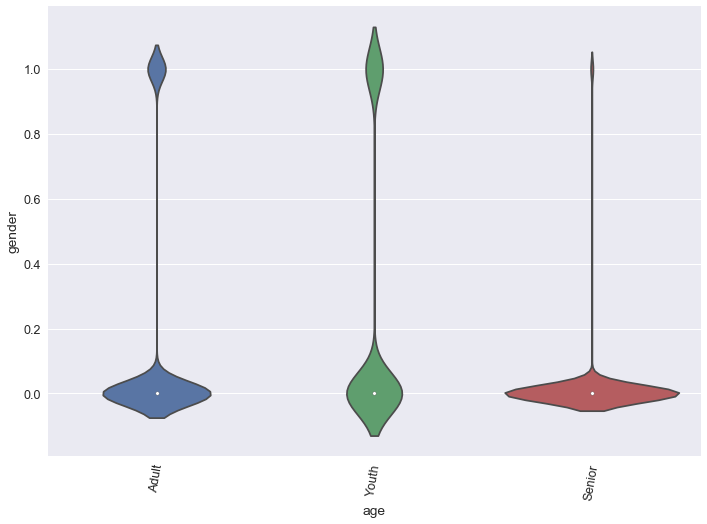

In [125]:
#Age
age = dataframe["age"].value_counts()
age_top_keys = list(age.keys())
condition_array = [False] * len(dataframe["age"])
for i in range(len(condition_array)):
    condition_array[i] = str(dataframe["age"].iloc[i]) in age_top_keys

g =sns.violinplot(x=dataframe["age"].loc[condition_array],y=dataframe["gender"].loc[condition_array])
g.set_xticklabels(g.get_xticklabels(),rotation=80)



We see how the 3 main values: adult, youth, senior take different shapes when comparing male and female in our violinplot, meaning that the age feature should provide us some information about the gender.

[Text(0,0,'AmericanEnglishn'),
 Text(0,0,'CanadianEnglishn'),
 Text(0,0,'EnglishEnglishn'),
 Text(0,0,'AustralianEnglishn'),
 Text(0,0,'EuropeanEnglishn'),
 Text(0,0,'BritishEnglishn'),
 Text(0,0,'IndianEnglishn'),
 Text(0,0,'Othern'),
 Text(0,0,'isDutchn'),
 Text(0,0,'AfricanEnglishn')]

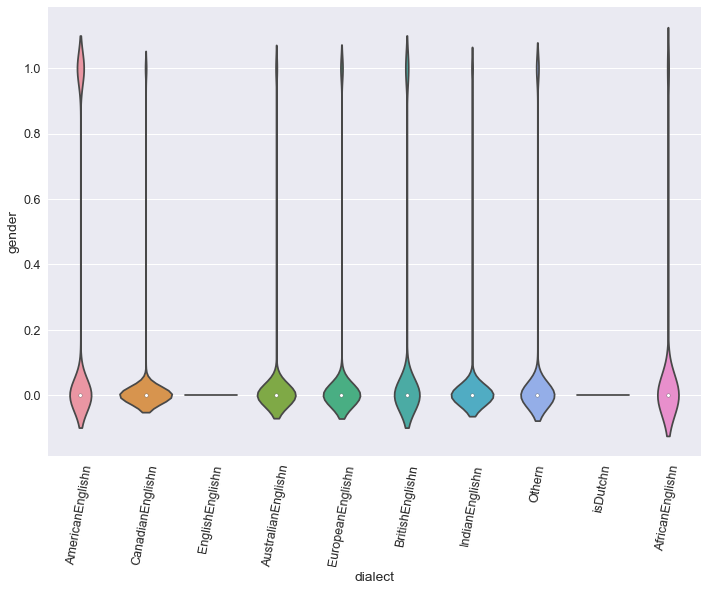

In [128]:
#Dialect
dialect = dataframe["dialect"].value_counts()
dialect_top_keys = list(dialect.keys())
condition_array = [False] * len(dataframe["dialect"])
for i in range(len(condition_array)):
    condition_array[i] = str(dataframe["dialect"].iloc[i]) in dialect_top_keys

g =sns.violinplot(x=dataframe["dialect"].loc[condition_array],y=dataframe["gender"].loc[condition_array])
g.set_xticklabels(g.get_xticklabels(),rotation=80)


With dialect we find the same as in age, different shapes with compared with gender (but less prominent). We will still keep the feature

We now transform categorical features to one hot, this now can be done very fast thanks to pandas.get_dummies()

In [129]:

dataframe = pd.get_dummies(dataframe,prefix_sep ="-")
print('\nDataframe shape: {}'.format(dataframe.shape))


Dataframe shape: (85093, 41)


In [130]:
#We update columns list, now there are only continuous features as we have transformed categorial to one hot
continuousFeatures = dataframe.select_dtypes(include=['float64','int64']).columns

In [131]:
dataframe.columns

Index(['gender', 'selec', 'meanfreq', 'sd', 'freq.median', 'freq.Q25',
       'freq.IQR', 'time.median', 'time.Q25', 'time.Q75', 'time.IQR', 'skew',
       'kurt', 'time.ent', 'entropy', 'sfm', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'startdom',
       'enddom', 'dfslope', 'meanpeakf', 'age-Adult', 'age-Senior',
       'age-Youth', 'dialect-AfricanEnglishn', 'dialect-AmericanEnglishn',
       'dialect-AustralianEnglishn', 'dialect-BritishEnglishn',
       'dialect-CanadianEnglishn', 'dialect-EnglishEnglishn',
       'dialect-EuropeanEnglishn', 'dialect-IndianEnglishn', 'dialect-Othern',
       'dialect-isDutchn'],
      dtype='object')

# Preprocessing

## Dataframe irregularities

We now apply some irregularities fixing methods for our dataset such as:

Cleaning features with >98% zeros, 100% nans, constant values or duplicated

In [132]:
#Remove features with a high % of zeros, >98%
zero_count = []
cols_to_drop = []
for col in dataframe.columns:
    aux=[i[1] for i in list(dataframe[col].value_counts().items()) if (i[0] == 0)]
    if aux!=[]:
        zero_count.append(aux[0])
        if (aux[0]>=dataframe.shape[0]*0.98):
            cols_to_drop.append(col)
    else:
        zero_count.append(0)
print('{0} features of {1} have zeroes in 99% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.99]),dataframe.shape[1]))
print('{0} features of {1} have zeroes in 98% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.98]),dataframe.shape[1]))
print('{0} features of {1} have zeroes in 97% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.97]),dataframe.shape[1]))
print('{0} features of {1} have zeroes in 96% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.96]),dataframe.shape[1]))
print('{0} features of {1} have zeroes in 95% or more samples.'.format(len([i for i in zero_count if i >= dataframe.shape[0] * 0.95]),dataframe.shape[1]))

#cols_to_drop = [col for col in X_train.columns[2:] if [i[1] for i in list(X_train[col].value_counts().items()) if i[0] == 0][0] >= 4459 * 0.98]
dataframe=dataframe.drop(cols_to_drop, axis=1)
print('Removing features with more than 98% zeroes:{0}'.format(cols_to_drop))
print('\nDataframe shape: {}'.format(dataframe.shape))

2 features of 41 have zeroes in 99% or more samples.
5 features of 41 have zeroes in 98% or more samples.
5 features of 41 have zeroes in 97% or more samples.
7 features of 41 have zeroes in 96% or more samples.
7 features of 41 have zeroes in 95% or more samples.
Removing features with more than 98% zeroes:['dfslope', 'age-Senior', 'dialect-AfricanEnglishn', 'dialect-EnglishEnglishn', 'dialect-isDutchn']

Dataframe shape: (85093, 36)


In [133]:
print('Removing features with more than 100% NaNs')
dataframe.dropna(axis=1, how='all', inplace=True)
print('\nDataframe shape: {}'.format(dataframe.shape))

Removing features with more than 100% NaNs

Dataframe shape: (85093, 36)


In [134]:
# remove constant features in the dataframe
nunique = dataframe.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
        

dataframe.drop(cols_to_drop, axis=1, inplace=True)

print("Removed `{}` Constant features\n".format(len(cols_to_drop)))
print(cols_to_drop)
print('\nDataframe shape: {}'.format(dataframe.shape))

Removed `1` Constant features

Index(['selec'], dtype='object')

Dataframe shape: (85093, 35)


In [135]:
#Remove duplicated columns

colsToRemove = []
colsScaned = []
dupList = {}

columns = dataframe.columns

for i in range(len(columns)-1):
    v = dataframe[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, dataframe[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
                
# remove duplicate columns in the training set
dataframe.drop(colsToRemove, axis=1, inplace=True) 

print("Removed `{}` Duplicate Columns\n".format(len(dupList)))
print(dupList)

print('\nDataframe shape: {}'.format(dataframe.shape))

Removed `0` Duplicate Columns

{}

Dataframe shape: (85093, 35)


In [136]:
#update column indices
continuousFeatures = dataframe.select_dtypes(include=['float64','int64']).columns
categoricalFeatures = dataframe.select_dtypes(include='object').columns

## Prepare the data

### Balancing data

#### Upsample and downsampling

When balancing a dataset we can either upsample the minority (female in our case) or downsample the majority (male), when upsampling we could use oversampling methods suchs as SMOTE and ADASYN. 

In the other hand when we downsample the resultant set will be just a portion from the original one, having only originalsamples.

We will always choose downsample if we have enough samples for our problem, in our case 12k samples seems fair enough.

In [137]:
# Separate majority and minority classes
df_majority = dataframe[dataframe.gender==0]
df_minority = dataframe[dataframe.gender==1]
 
# Upsample minority class, we will not be upsampling today 
#df_minority_upsampled = resample(df_minority, 
#                                 replace=True,     # sample with replacement
#                                 n_samples=len(dataframe.loc[dataframe['gender'] == 0]),    # to match majority class
#                                 random_state=17) # reproducible results
 
# Combine majority class with upsampled minority class
#dataframe_upsampled = pd.concat([df_majority, df_minority_upsampled])
 # Display new class counts
#dataframe_upsampled.gender.value_counts()

 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(dataframe.loc[dataframe['gender'] == 1]),     # to match minority class
                                 random_state=17) # reproducible results
 
# Combine minority class with downsampled majority class
dataframe_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
dataframe_downsampled.gender.value_counts()

1    12932
0    12932
Name: gender, dtype: int64

We now have a new balanced dataset **dataframe_downsampled** that comes from downsampling the original one

### Expanding the dataset with external sources

Another way to balance our dataset its to add samples from the minority set, we have found a dataset audio.csv in the internet https://www.kaggle.com/rohankale/voice-recognition where features are the same as the ones we obtained from the specan method in warbleR (but not the ones we took from the tgz files). Meaning that we will have to cut features from our original dataset in order to be able to concat this new dataset with ours. 

We will still have to downsample the minority class but our resultant number will be greater than before.

In [138]:
dfExtra = pd.read_csv('voice.csv')

print("Merging existing dataframe with new dataframe of shape{0}".format(dfExtra.shape))

dfExtra=dfExtra.rename(index=str,columns = { #Rename variables to allow concat
    'label':'gender',
    'median':'freq.median',
    'Q25':'time.Q25',
    'Q75':'time.Q75',
    'IQR':'time.IQR',
    'sp.ent':'time.ent',
    })


dfExtra.drop(['mode', 'centroid'],axis=1,inplace=True) # Drop variables not avaliable in our dataset
dfExtra['gender'] = dfExtra['gender'].map({'female': 1, 'male': 0}) #Encode the target variable

dataframe=dataframe[dfExtra.columns] #The two datasets now use same features

dfExtra=dfExtra.append(dataframe)

print("Columns for the extended dataframe{0}".format(dfExtra.columns))



#Downsample to the minority class
# Separate majority and minority classes
df_majority = dfExtra[dfExtra.gender==0]
df_minority = dfExtra[dfExtra.gender==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(dfExtra.loc[dfExtra['gender'] == 1]),     # to match minority class
                                 random_state=17) # reproducible results

# Combine minority class with downsampled majority class
dfExtra_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print("New class balance:")
print(dfExtra_downsampled.gender.value_counts())

print('dfExtra_downsampled shape: {}'.format(dfExtra_downsampled.shape))

Merging existing dataframe with new dataframe of shape(3168, 21)
Columns for the extended dataframeIndex(['meanfreq', 'sd', 'freq.median', 'time.Q25', 'time.Q75', 'time.IQR',
       'skew', 'kurt', 'time.ent', 'sfm', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'gender'],
      dtype='object')
New class balance:
1    14516
0    14516
Name: gender, dtype: int64
dfExtra_downsampled shape: (29032, 19)


We now added 1584 new elements at the cost of losing some features. 

From now on we will perform feature selection and model analysis for the two datasets **dataframe_downsampled** and **dfExtra_downsampled**, if at one moment we ensure that one of the two datasets its better we will only continue with that one.

### Prepare splits for scoring without cross validation 

We now do the splits needed for training and testing purposes of all of our models when not using cv.

Firstly the dataset_downsampled and dfExtra_downsampled will be splitted, then we will evaluate a feature extraction for our first dataset_downsampled as it counts with a larger number of features. To do so we will use 2 different tree models (extratrees and randoforest) in which we can see the features that give us more importance when prunning.

We have choosed tree models for feature extraction rather than typical goodness of fit test such as two sample Kolmogorov–Smirnov test (where you can compare two series with the null hypothesis is that those two samples are drawn from the same distribution). The reason for this is that in our preelimnary review of the dataset (see continuous variable analysis) we saw how the distributions of the features for male or female weren't that different, we were able to see some different behaviour but overall they will always pass the K-S test. By letting tree models decide our top features we are choosing the features that contain more information regarding target=gender

In [139]:
#Reduce df size for faster computs if you want
#dataframe_downsampled = dataframe_downsampled.sample(30000)
#dfExtra_downsampled = dfExtra_downsampled.sample(30000)


In [140]:
#dataframe_downsampled will be default name
train, test = train_test_split(dataframe_downsampled, test_size=0.2)

# Scale the data to be between -1 and 1

scaler = StandardScaler()
X = scaler.fit_transform(dataframe_downsampled.drop('gender',axis =1))


train_columns = dataframe_downsampled.drop('gender',axis =1).columns
y = dataframe_downsampled['gender']

X_train= scaler.transform(train.drop('gender',axis=1))
y_train=train['gender']

X_test= scaler.transform(test.drop('gender',axis=1))
y_test=test['gender']

#dfExtra_downsampled
train_Extra, test_Extra = train_test_split(dfExtra_downsampled, test_size=0.2)

# Scale the data to be between -1 and 1

scaler_Extra = StandardScaler()
X_Extra = scaler_Extra.fit_transform(dfExtra_downsampled.drop('gender',axis =1))

train_columns_Extra = dfExtra_downsampled.drop('gender',axis =1).columns
y_Extra = dfExtra_downsampled['gender']

X_train_Extra=scaler_Extra.transform(train_Extra.drop('gender',axis=1))
y_train_Extra=train_Extra['gender']

X_test_Extra=scaler_Extra.transform(test_Extra.drop('gender',axis=1))
y_test_Extra=test_Extra['gender']

## Feature selection

When looking to extract features from a dataset we will ideally only choose those who contain information regarding the target variable.Most common ways are:
    
--Study correlation between the target and the feature. #Done

--Study correlation between features and remove those very correlated(duplicated information) #Done

--Study distributions in the feature when splitting by target feature. #Done

--Apply decomposition techniques such as PCA were we convert a set of observations of possibly correlated variables(original dataset) into a set of values of linearly uncorrelated variables. #We wont be doing this technique now as we would like a model coming from original features to be able to provide insights the features. But weill include this in our possible improvements list 

--Fit models with the dataset and see which features provide you the most information in the model.

We will now do last point, we have choosed tree models (extratrees and randomforest) as they provide us with information scores for the featues thanks to the model nature. We will compare the most important features from this models with the ones we have observed from our features before in their analysis.

##### We will only apply this methods to the dataframe_downsampled and not to the extended one as dfExtra_downsampled already counts with a lower number of features




### Dataframe_downsampled

#### ExtraTrees

In [141]:
# Build a forest and compute the feature importances, you can choose extratrees or randomforest up to you but this is faster
forest = ExtraTreesClassifier(n_estimators=10000,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]




In [142]:
# Print the feature ranking
print("Feature ranking with extratrees in dataframe_downsampled:")

for f in range(X.shape[1])[:30]:
    print("%d. feature %s (%f)" % (f + 1, train_columns[indices[f]], importances[indices[f]]))


Feature ranking with extratrees in dataframe_downsampled:
1. feature dialect-AmericanEnglishn (0.086183)
2. feature meanfun (0.071112)
3. feature meanpeakf (0.069824)
4. feature freq.Q25 (0.044148)
5. feature maxdom (0.039542)
6. feature dfrange (0.038773)
7. feature skew (0.037182)
8. feature freq.IQR (0.036502)
9. feature sfm (0.035984)
10. feature freq.median (0.034685)
11. feature entropy (0.034001)
12. feature sd (0.033965)
13. feature kurt (0.032711)
14. feature meandom (0.032582)
15. feature time.ent (0.029664)
16. feature modindx (0.029617)
17. feature meanfreq (0.029416)
18. feature time.IQR (0.026267)
19. feature time.Q25 (0.025976)
20. feature mindom (0.024689)
21. feature startdom (0.024182)
22. feature minfun (0.022991)
23. feature time.Q75 (0.022970)
24. feature time.median (0.022602)
25. feature enddom (0.022500)
26. feature dialect-EuropeanEnglishn (0.017188)
27. feature age-Youth (0.014286)
28. feature age-Adult (0.012213)
29. feature dialect-CanadianEnglishn (0.011985

### dfextra version




In [143]:
forest = ExtraTreesClassifier(n_estimators=1000,
                              random_state=0)

forest.fit(X_Extra, y_Extra)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [199]:
# Print the feature ranking
print("Feature ranking with extratrees in dfExtra_downsampled:")

for f in range(X.shape[1])[:18]:
    print("%d. feature %s (%f)" % (f + 1, train_columns_Extra[indices[f]], importances[indices[f]]))


Feature ranking with extratrees in dfExtra_downsampled:
1. feature meanfun (0.140326)
2. feature maxdom (0.059000)
3. feature sd (0.057717)
4. feature dfrange (0.057697)
5. feature skew (0.057354)
6. feature sfm (0.056164)
7. feature freq.median (0.055328)
8. feature meandom (0.054985)
9. feature time.ent (0.054324)
10. feature modindx (0.053272)
11. feature time.Q25 (0.053231)
12. feature time.IQR (0.052754)
13. feature meanfreq (0.051558)
14. feature kurt (0.050438)
15. feature minfun (0.045019)
16. feature mindom (0.043720)
17. feature time.Q75 (0.043283)
18. feature maxfun (0.013829)


#### RandomForest

In [144]:
#Feature selection with random forest

clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

features = train_columns
importances = clf.feature_importances_
indices = np.argsort(importances)

    




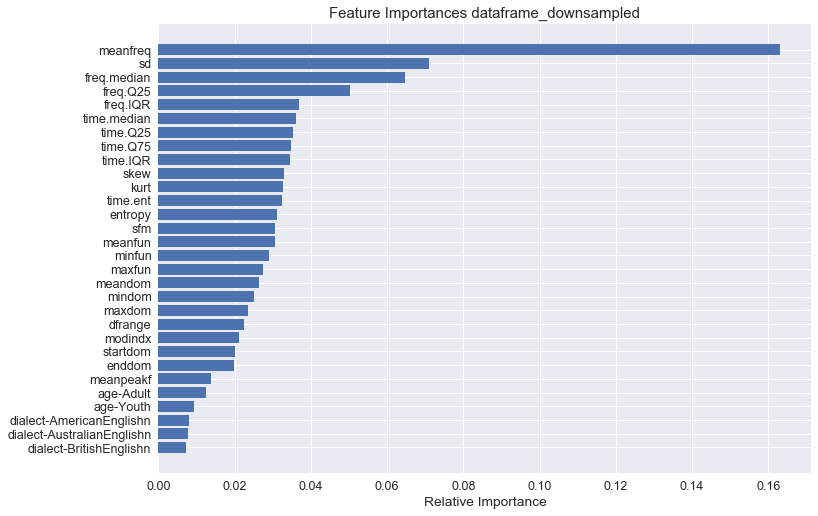

In [145]:
#Feature importance chart, just top 30
importances20 = np.array(sorted(importances, reverse=True)[:30])
indices20 = np.argsort(importances20)

top20_RF_dataframe_downsampled = [features[i] for i in indices20]

plt.title('Feature Importances dataframe_downsampled')
plt.barh(range(len(indices20)), importances20[indices20], align='center')
plt.yticks(range(len(indices20)),top20_RF_dataframe_downsampled)
plt.xlabel('Relative Importance')
plt.show()



Results from our randomForest and extratrees are almost similar but we can see how rf gives us some features as important that we already saw on feature analysis, we will keep the top 20 features from rf to build a new dataset.

In [148]:
#We create now a new dataset with a selection of the best 20 features, we will test it agains others in SVM to choose the best one and then move to better models with it
#dataframe_downsampled will be default name

top20_RF_dataframe_downsampled.append('gender')
train_reduced, test_reduced = train_test_split(dataframe_downsampled[top20_RF_dataframe_downsampled], test_size=0.2)

# Scale the data to be between -1 and 1

scaler_reduced = StandardScaler()
X_reduced = scaler_reduced.fit_transform(dataframe_downsampled[top20_RF_dataframe_downsampled].drop('gender',axis =1))


train_columns_reduced = dataframe_downsampled[top20_RF_dataframe_downsampled].drop('gender',axis =1).columns
y_reduced = dataframe_downsampled[top20_RF_dataframe_downsampled]['gender']

X_train_reduced= scaler_reduced.transform(train_reduced.drop('gender',axis=1))
y_train_reduced=train_reduced['gender']

X_test_reduced= scaler_reduced.transform(test_reduced.drop('gender',axis=1))
y_test_reduced=test_reduced['gender']


### dFextra_downsampled

We wont be selecting features from dfExtra_downsampled dataset as they are already less than the original dataset and we don't expect better performance if we do. But for the sake of knowledge we can show the top20 features with the choosed model for feature extraction(rf) and see if they are similar to dataframe_downsampled_reduced

In [149]:
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train_Extra, y_train_Extra)

features = train_columns_Extra
importances = clf.feature_importances_
indices = np.argsort(importances)

  

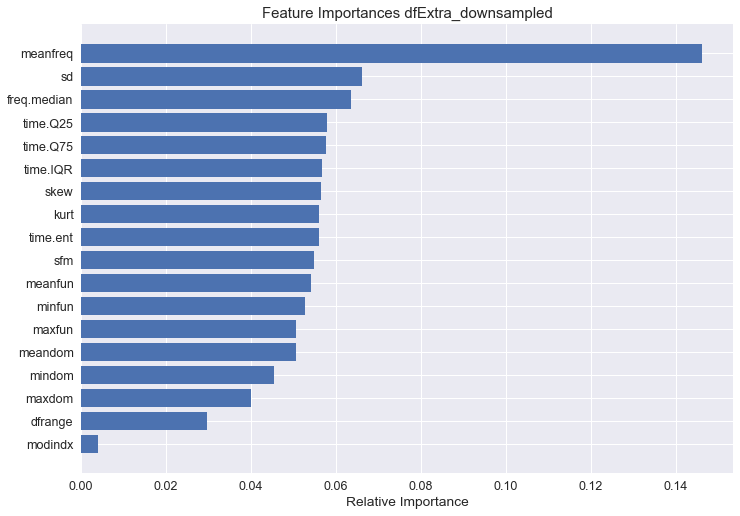

In [150]:
from matplotlib import cm
#Feature importance chart, just top 30
importances20 = np.array(sorted(importances, reverse=True)[:30])
indices20 = np.argsort(importances20)

top20_RF_dfExtra_downsampled = [features[i] for i in indices20]

plt.set_cmap('hot')
plt.title('Feature Importances dfExtra_downsampled')
plt.barh(range(len(indices20)), importances20[indices20], align='center',)
plt.yticks(range(len(indices20)), top20_RF_dfExtra_downsampled)
plt.xlabel('Relative Importance')
plt.show()

Important features for this dataset are almost equal as for the original one but with the difference that ***dataframe_downsampled*** has age and dialect (this may lead the original dataset to better results as this variables represent information dfExtra doesnt have)

# Building the model

We now proceed to study several models for our dataset: SVM (different kernels) XGBoost, DNN. We know that they are a high number of models we could try too but we find this 3 models representative to the algorithm they use (kernels,trees & Gradient boosting, deep learning). More models such as RF, Gradient Boosting, Logistic Regression but we have limited time so we will focus on the best of their field.

## Choosing the metric for our models

They are several metrics used for binnary classification problems but choosing the right metric depends on the purpose and nature of our model. From what we know for the problem avoiding false negatives is not more important than getting true positives(that would be the case if you were trying to detect people getting to rob in a building, where you prefer false positives rather than false negatives), in our problem false negative and false positive have the same weight (we can't say the opposite if we don't know this models applications for real life) so we will use standar accuracy where we maximize the true positives.

Metrics like AUC (true positive rate against false positive rate) or others metrics like F-1 will have no sense to be used here even if they are widely use in binnary classification problems, same reason as we stated above. 

We will use cross validation in all models we are able to, cv provide us with a more robust score without sensitive to the train/test split.

## SVM

### SVM kernels, without cv

In [151]:
#Trying different kernels
print("dataframe_downsampled scores")
svc=SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('--Linear kernel accuracy_score: {0}'.format(metrics.accuracy_score(y_test,y_pred)))

svc=SVC(kernel='rbf')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('--Radial basis function accuracy_score: {0}'.format(metrics.accuracy_score(y_test,y_pred)))

svc=SVC(kernel='poly')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('--Polinomial accuracy_score: {0}'.format(metrics.accuracy_score(y_test,y_pred)))

#Trying different kernels
print(" \ndataframe_downsampled_reduced scores")
svc=SVC(kernel='linear')
svc.fit(X_train_reduced,y_train_reduced)
y_pred=svc.predict(X_test_reduced)
print('--Linear kernel roc_auc_score:{0}'.format(metrics.accuracy_score(y_test_reduced,y_pred)))

svc=SVC(kernel='rbf')
svc.fit(X_train_reduced,y_train_reduced)
y_pred=svc.predict(X_test_reduced)
print('--Radial basis function accuracy_score: {0}'.format(metrics.accuracy_score(y_test_reduced,y_pred)))

svc=SVC(kernel='poly')
svc.fit(X_train_reduced,y_train_reduced)
y_pred=svc.predict(X_test_reduced)
print('--Polinomial accuracy_score: {0}'.format(metrics.accuracy_score(y_test_reduced,y_pred)))

print(" \ndfExtra_downsampled scores:")

svc=SVC(kernel='linear')
svc.fit(X_train_Extra,y_train_Extra)
y_pred=svc.predict(X_test_Extra)
print('--Linear kernel accuracy_score: {0}'.format(metrics.accuracy_score(y_test_Extra,y_pred)))

svc=SVC(kernel='rbf')
svc.fit(X_train_Extra,y_train_Extra)
y_pred=svc.predict(X_test_Extra)
print('--Radial basis function  accuracy_score: {0}'.format(metrics.accuracy_score(y_test_Extra,y_pred)))

svc=SVC(kernel='poly')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('--Polinomial accuracy_score: {0}'.format(metrics.accuracy_score(y_test,y_pred)))

dataframe_downsampled scores
--Linear kernel accuracy_score: 0.7575874734196791
--Radial basis function accuracy_score: 0.8465107287840712
--Polinomial accuracy_score: 0.8043688381983375
 
dataframe_downsampled_reduced scores
--Linear kernel roc_auc_score:0.7436690508409047
--Radial basis function accuracy_score: 0.8424511888652619
--Polinomial accuracy_score: 0.8171273922288808
 
dfExtra_downsampled scores:
--Linear kernel accuracy_score: 0.691751334596177
--Radial basis function  accuracy_score: 0.7819872567590839
--Polinomial accuracy_score: 0.8043688381983375


### SVM with CV

In [152]:
#SVM with cross validation
from sklearn.cross_validation import cross_val_score

dataframe_score = []
dfExtra_score = []
dataframe_reduced_score = []

print("dataframe_downsampled cv accuracy scores:")
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
dataframe_score.append(scores.mean())
print(" Linear CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='rbf')
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
dataframe_score.append(scores.mean())
print(" Radial basis CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='poly')
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy') #cv is cross validation
dataframe_score.append(scores.mean())
print(" Polinomial CV accuracy:{0}".format(scores.mean()))

print("dataframe_downsampled_reduced cv accuracy scores:")
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X_reduced, y_reduced, cv=10, scoring='accuracy') #cv is cross validation
dataframe_reduced_score.append(scores.mean())
print(" Linear CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='rbf')
scores = cross_val_score(svc, X_reduced, y_reduced, cv=10, scoring='accuracy') #cv is cross validation
dataframe_reduced_score.append(scores.mean())
print(" Radial basis CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='poly')
scores = cross_val_score(svc, X_reduced, y_reduced, cv=10, scoring='accuracy') #cv is cross validation
dataframe_reduced_score.append(scores.mean())
print(" Polinomial CV accuracy:{0}".format(scores.mean()))

print("dfExtra_downsampled cv accuracy scores:")
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X_Extra, y_Extra, cv=10, scoring='accuracy') #cv is cross validation
dfExtra_score.append(scores.mean())
print(" Linear CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='rbf')
scores = cross_val_score(svc, X_Extra, y_Extra, cv=10, scoring='accuracy') #cv is cross validation
dfExtra_score.append(scores.mean())
print(" Radial basis CV accuracy:{0}".format(scores.mean()))

svc=SVC(kernel='poly')
scores = cross_val_score(svc, X_Extra, y_Extra, cv=10, scoring='accuracy') #cv is cross validation
dfExtra_score.append(scores.mean())
print(" Polinomial CV accuracy:{0}".format(scores.mean()))

dataframe_downsampled cv accuracy scores:
 Linear CV accuracy:0.7434328347504277
 Radial basis CV accuracy:0.8158118677314897
 Polinomial CV accuracy:0.7804695297828876
dataframe_downsampled_reduced cv accuracy scores:
 Linear CV accuracy:0.7402230952304107
 Radial basis CV accuracy:0.8119841890287853
 Polinomial CV accuracy:0.788745336618171
dfExtra_downsampled cv accuracy scores:
 Linear CV accuracy:0.6721621404825778
 Radial basis CV accuracy:0.725452143767099
 Polinomial CV accuracy:0.6888040783120979


Let's print the CV accuracy scores and see which dataset of the three we are using its better.

<Figure size 7200x7200 with 0 Axes>

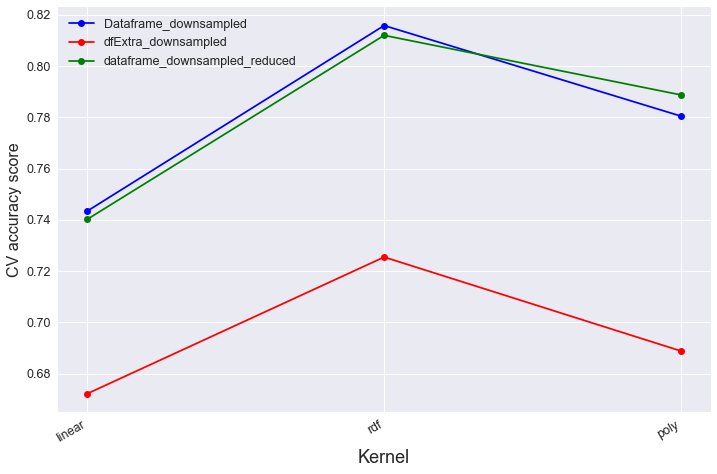

In [154]:
data = pd.DataFrame({"dataframe_downsampled":dataframe_score, "dfExtra_downsampled":dfExtra_score,"Kernel":["linear","rbf","poly"]})
kernel = ["linear","rdf","poly"]
df1 = pd.DataFrame({"kernel":kernel, "score" : dataframe_score})
df2 = pd.DataFrame({"kernel":kernel, "score" : dfExtra_score})
df3 = pd.DataFrame({"kernel":kernel, "score" : dataframe_reduced_score})

plt.figure(figsize=(100,100))

f, ax = plt.subplots(1, 1)
x_col='Kernel'
y_col = 'Accuracy score'

ax.plot_date(df1.kernel, df1["score"], color="blue", label="Dataframe_downsampled", linestyle="-")
ax.plot_date(df2.kernel, df2["score"], color="red", label="dfExtra_downsampled", linestyle="-")
ax.plot_date(df3.kernel, df3["score"], color="green", label="dataframe_downsampled_reduced", linestyle="-")

ax.legend()
plt.xlabel('Kernel', fontsize=18)
plt.ylabel('CV accuracy score', fontsize=16)
plt.gcf().autofmt_xdate()
plt.show()

Seems like radial basis function performs the best in the three datasets, with the top accuracy at the ***dataframe_downsampled*** dataset.

**dataframe_reduced_score** and ***dataframe_downsampled*** have very similar results so we are not able to select one right now, let's see their performance in XGBoost and decided which dataset use to tune parameters and DNN.





we decided to go with ***dataframe_downsampled*** for next models and parameter tunning due to its categorical features as accuracy score doesnt give us enough reason to decide. This is subject to change depending on the project purposes and the avaliable features in real life, now we dont have enough information to decide.

## XGBoost with cv

We will use xgboost with the best parameters I could decide by my own judge and the parameter impact on the model for our problem.

In [160]:
#Out of the box model with start parameters
  #Perforing grid search

# xgboost model dataframe_downsampled
xgtrain = xgb.DMatrix(X, label=y)
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=17)
xgb_param = clf.get_xgb_params()
##do cross validation
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['error'],
     early_stopping_rounds=50, stratified=True, seed=17)
print('Overall accuracy for xgboost dataframe_downsampled:: {0}'.format(1-cvresult['test-error-mean'].values[-1]))

# xgboost model dataframe_downsampled
xgtrain = xgb.DMatrix(X_reduced, label=y_reduced)
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=17)
xgb_param = clf.get_xgb_params()
##do cross validation
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['error'],
     early_stopping_rounds=50, stratified=True, seed=17)
print('Overall accuracy for xgboost dataframe_downsampled_reduced: {0}'.format(1-cvresult['test-error-mean'].values[-1]))


# xgboost model dfExtra_downsampled
xgtrain = xgb.DMatrix(X_Extra, label=y_Extra)
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=700,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=17)
xgb_param = clf.get_xgb_params()
##do cross validation
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['error'],
     early_stopping_rounds=50, stratified=True, seed=17)
print('Overall accuracy for xgboost dfExtra_downsampled: {0}'.format(1-cvresult['test-error-mean'].values[-1]))


Overall accuracy for xgboost dataframe_downsampled:: 0.8925147999999999
Overall accuracy for xgboost dataframe_downsampled_reduced: 0.8915488666666667
Overall accuracy for xgboost dfExtra_downsampled: 0.8232297333333334


## Tuning the model parameters

SVM models take only one parameter and we already know the optimal range of values for the three different kernels(Thanks to the previos models) so we could find their optimal values by hand or using a simple greadSearch algorithm from the package sklearn.

We present both approaches here.

#### NOTE: This part its not executed for its required computing time but we provide the code necessary for it.

### SVM

#### Linear kernel

In [ ]:
'''
The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. 
For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely,
a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane,
even if that hyperplane misclassifies more points.
'''
C_range=list(range(1,26))

acc_score=[]
for c in C_range:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

plt.plot(C_range,acc_score)
plt.xticks(np.arange(0,27,2))
plt.xlabel('Value of C for SVC, linear')
plt.ylabel('Cross-Validated Accuracy')

We see higher scores with C between X and Y, lets find the optima C in that space

In [ ]:
#Lets explore now the range where the accuracy was higher
C_range=list(np.arange(0.1,6,0.1))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

plt.plot(C_range,acc_score)
plt.xticks(np.arange(0.0,6,0.3))
plt.xlabel('Value of C for SVC ')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
#Comentar que cojemos el maximo

#### Radial basis function kernel

In [ ]:
'''
Technically, the gamma parameter is the inverse of the standard deviation of the RBF kernel (Gaussian function),
which is used as similarity measure between two points. Intuitively, a small gamma value define a Gaussian function with a large variance. In this case, two points can be considered similar even if are far from each other. In the other hand, a large gamma value means define a Gaussian function with a small variance and in this case, 
two points are considered similar just if they are close to each other
'''

gamma_range=[0.0001,0.001,0.01,0.1,1,10,100]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
    
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.xticks(np.arange(0.0001,100,5))
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
#Lets explore now the range where the accuracy was higher
gamma_range=[0.0001,0.001,0.01,0.1,0.2]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)  

plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.ylabel('Cross-Validated Accuracy')

#### Polinomial kernel

In [ ]:
degree=[1,1.5,2,2.5,3]
acc_score=[]
for d in degree:
    svc = SVC(kernel='poly', degree=d)
    scores = cross_val_score(svc, X, y, cv=10, scoring='roc_auc')
    acc_score.append(scores.mean())
print(acc_score)  

plt.plot(degree,acc_score,color='r')
plt.xlabel('degrees for SVC ')
plt.ylabel('Cross-Validated Accuracy')


In [ ]:
#Lets explore now the range where the accuracy was higher
degree=list(np.arange(1,3,0.1))
acc_score=[]
for d in degree:
    svc = SVC(kernel='poly', degree=d)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

plt.plot(degree,acc_score)
plt.xticks(np.arange(1,3,0.3))
plt.xlabel('degrees for SVC ')
plt.ylabel('Cross-Validated Accuracy')

####  Grid search to find the best parameters

Another way to tune hyperparameters would be grid search

In [ ]:
svm= SVC()

tuned_parameters = {
 'C': list(np.arange(0.1,6,0.1)) , 'kernel': ['linear'],
 'C': list(np.arange(0.1,6,0.1)) , 'gamma': [0.0001,0.001,0.01,0.1,0.2], 'kernel': ['rbf'],
 'degree': [1,1.5,2,2.5,3] ,'gamma':[0.0001,0.001,0.01,0.1,0.2], 'C':list(np.arange(0.1,6,0.1)) , 'kernel':['poly']
                   }



model_svm = GridSearchCV(svm, tuned_parameters,cv=10,scoring='accuracy',n_jobs=22) #allow parallelization

In [ ]:
model_svm.fit(X_train, y_train)
print("Top accuracy: {0} with parameters: {1}".format(model_svm.best_score_.model_svm.best_params_))

### XGBoost

XGboost is a great gradient boosted trees algorithm but unlike SVM its very difficult to evaluate its optimal parameters due to their higher count. The space created by all the possible arguments its huge and we don't know its structure or how the parameters interact between them in this space to get a better score. Due to this new difficulty we present a new optimization technique Bayes Optimization, this technique is built to optimize black-box problems as the one we are against right now.

We will use the python package BayesianOptimization(more at https://github.com/fmfn/BayesianOptimization), defining the function to optimize the xgboost cross-validated training and scoring and the parameters being all posible xgboost parameters.

This process takes around a night at i3 6100 so run it at your own risk :) #Gridsearch will just be imposible

#### Tunning all parameters with bayes_opt

In [ ]:
#We now tune parameters, we will use bayesian opt and not grid search due to the large ammount of parameters for xgboost
xgtrain = xgb.DMatrix(X_train, label=y_train)


def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)


    cv_result = xgb.cv(params, xgtrain, num_boost_round=100, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(5)])
    return -cv_result['test-accuracy-mean'].values[-1]





random_state = 17
num_iter = 50
init_points = 25
params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'accuracy',
    'verbose_eval': True,
    'seed': random_state
}

xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 20),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 15),
                                            'alpha': (0, 15),
                                            })

xgbBO.maximize(init_points=init_points, n_iter=num_iter)

print(xgbBO.res['max'])

## DNN

### Basic neural network step by step


In this section a standard DNN model is presented, the structure for our dnn its (x_train.size,15,10,prediction). Dropout has been applied to our layers in order to give it more consinstency and help avoiding overfitting. 

Due to the binary classification problem we encounter we have choosed relu activation function for inner layers and sigmoid for the output layer (the output represents the probability of a test sample being a gender). The loss function its sigmoid_cross_entropy_with_logits and the optimizer its Adam with learning rate decay. We will train for 5000 epochs and the data will be given in batches. In order to avoid overfitting we should choose the epoch were test accuracy remains the same and training accuracy grows alone.

In [161]:
#Transform y to (-1,2) so each class has it's 'identifier' and the nn can have output 2 
y_train= (y_train[:,None] != np.arange(2)).astype(int)
y_test= (y_test[:,None] != np.arange(2)).astype(int)

In [162]:
#Easy wrapper for building layers
def layer(input, n_input, n_output, name='hidden_layer'):
    W = tf.Variable(tf.truncated_normal([n_input,n_output], stddev=0.1), name='W')
    B = tf.Variable(tf.constant(0.1, dtype=tf.float32, shape=[n_output]), name='B')
    return tf.add(tf.matmul(input,W), B)

# Buildng the model
x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]], name="x")
y = tf.placeholder(tf.float32, shape=[None, 2], name="y_")

hidden_1 = tf.nn.relu(layer(x, X_train.shape[1], 15, 'hidden_layer_1'))
hidden_1_dropout = tf.nn.dropout(hidden_1,keep_prob=0.9)
hidden_2 = tf.nn.relu(layer(hidden_1_dropout, 15, 10, 'hidden_layer_2'))
hidden_2_dropout = tf.nn.dropout(hidden_2,keep_prob=0.9)
hidden_3 = tf.nn.relu(layer(hidden_2_dropout, 10, 7, 'hidden_layer_3'))
hidden_3_dropout = tf.nn.dropout(hidden_3,keep_prob=0.9)
hidden_4 = tf.nn.relu(layer(hidden_3_dropout, 7, 5, 'hidden_layer_4'))
hidden_4_dropout = tf.nn.dropout(hidden_4,keep_prob=0.9)
output = tf.nn.sigmoid(layer(hidden_4_dropout, 5, 2, 'output'))

# Calculating loss function (sigmoid-cross-entropy)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=output, labels=y), name='xent')

# Training
optimizer = tf.train.AdamOptimizer(learning_rate=0.001,
    beta1=0.9, #betas for learning rate decay
    beta2=0.999,
    epsilon=1e-08,
    use_locking=False,
    name='Adam'
)
train = optimizer.minimize(loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1), name="correct_prediction")
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

In [164]:

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

num_epochs = 1000
batch_size = 100
train_size = X_train.shape[0]

for epoch in range(num_epochs):
    avg_accuracy = 0.0
    total_batches = int(train_size // batch_size)
    for step in range(total_batches):
        offset = (step * batch_size) % train_size
        batch_data = X_train[offset:(offset+batch_size),:]
        batch_labels = y_train[offset:(offset+batch_size)]
        _, ac = sess.run([train, accuracy], feed_dict={x: batch_data, y: batch_labels})
        avg_accuracy += ac / total_batches
    validation_accuracy = sess.run([accuracy], feed_dict= {x: X_test, y: y_test})
    if epoch % 50 == 0:
        print("Epoch:{} training_accuracy={}".format(epoch+1,avg_accuracy))
        print("Epoch:{} testing_accuracy={}".format(epoch+1,validation_accuracy))
        

Epoch:1 training_accuracy=0.6417475727576658
Epoch:1 testing_accuracy=[0.73284364]
Epoch:51 training_accuracy=0.8323300964045294
Epoch:51 testing_accuracy=[0.829306]
Epoch:101 training_accuracy=0.8383980575695782
Epoch:101 testing_accuracy=[0.8360719]
Epoch:151 training_accuracy=0.8429611658008358
Epoch:151 testing_accuracy=[0.83645856]
Epoch:201 training_accuracy=0.8453398037304002
Epoch:201 testing_accuracy=[0.8409047]
Epoch:251 training_accuracy=0.8464077659023621
Epoch:251 testing_accuracy=[0.8358786]
Epoch:301 training_accuracy=0.8480097084369479
Epoch:301 testing_accuracy=[0.83529866]
Epoch:351 training_accuracy=0.847330095987876
Epoch:351 testing_accuracy=[0.8362652]
Epoch:401 training_accuracy=0.8519902889010982
Epoch:401 testing_accuracy=[0.8432244]
Epoch:451 training_accuracy=0.8541262144023933
Epoch:451 testing_accuracy=[0.84051806]
Epoch:501 training_accuracy=0.8535922317250267
Epoch:501 testing_accuracy=[0.8407114]
Epoch:551 training_accuracy=0.8512135911913754
Epoch:551 t

# Conclusion and future work

To finalaze the model study we can see how the best model (without parameter tunning) is XGboost with almost 90% accuracy score. Xgboost models are famous for their binary classificator accuracy so it doesn't surprise us. Next model is DNN (avg 84% accuracy) (famous for classification too) which could probably win xgboost if well tunned and with a bigger network.

After finishing the project we can want to emphasize of dataset processing (either cleaning, adding new variables, removing new variables), this data processing leads us to better results and robust models. We have seen here how ***dataframe_downsampled*** has the best performance in our models due to its extra categorical features extracted from files in the tgz's. A data science project its not just the model creation but the search of insight in the data (taking into account the project purpose) to provide with the best model for the current situation.

For future work and possible improvements we will like to propose a list:
--Give another shot at reviewing the data to see if more insight can be extracted.

--Perform an comprehensive goodness of fit study of our featues with 2-Sample Kolormovit goodness of tit test, analyzing each feature when splitting by gender. This will provide us with more information for the feature extraction

--Tune the model parameters to achieve best performance for each of them (with the proposed methods).

--Tune the dnn with different compositions and loss/activation/optimizers.

--Studying the confusion matrix of our models to see if an emsemble could be usefull (getting a better score by using prediction of two models with similar accuracy but different errors in the test set).

--Get to know the nature/purpose of the project to be able to trick the project and see it with a diferent perspective.

--Perform decomposition techniques such as PCA to get uncorrelated features in case the nature of the project allows it (a reason we have done it, apart of time)

Overall the project has been quite fun and treating with audio files was our first time. A good solution has been presented but a lot of improvements could be done :).

Thanks to Sandvik CODE and Lukasz to present us with this assignment.
